# Compare level of agreement in clinical decision making between hospitals using Random Forests models

## Aims:

* Quantify the level of agreement between different hospital models on what treatment patients should receive.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

## Load data

Create combined data set by combining cohort train/test

In [2]:
data = pd.concat([
    pd.read_csv('./../data/10k_training_test/cohort_10000_train.csv'),
    pd.read_csv('./../data/10k_training_test/cohort_10000_test.csv')],
    axis=0)

data = data.sample(frac=1.0, random_state=42)

hospitals = list(set(data['StrokeTeam'].values))

## Load previously saved models

In [3]:
with open ('./models/trained_hospital_models.pkl', 'rb') as f:
    hospital2model = pkl.load(f)

## Pass patients from each hospital through all other hospital models

In [4]:
# calculate results if not previously saved, else load previously saved results
calculate_results = True

# Calculate and save results if needed
if calculate_results:

    # create df for results
    results = pd.DataFrame(
        columns = np.concatenate((['True','Hospital'],hospitals)))
    
    results_prob = pd.DataFrame(
        columns = np.concatenate((['True','Hospital'],hospitals)))
    
    counter = 0

    # loop through patients from each hospital
    for hospital_test in hospitals:
        
        # Show progress
        counter += 1
        print (f'Calculating {counter} of {len(hospitals)}', end='\r')

        # df for each hospital's results
        hospital_results = pd.DataFrame(
            columns = np.concatenate((['True','Hospital'],hospitals)))
        
        hospital_results_prob = pd.DataFrame(
            columns = np.concatenate((['True','Hospital'],hospitals)))

        _, _, X_test, y_test = hospital2model[hospital_test]

        # put patients from hospital_test through all other hospital models
        for hospital_train in hospitals:

            if hospital_test==hospital_train:

                hospital_results['True'] = y_test
                hospital_results['Hospital'] = [hospital_test for v in y_test]
                hospital_results_prob['True'] = y_test
                hospital_results_prob['Hospital'] = [hospital_test for v in y_test]

            forest, threshold, _,_ = hospital2model[hospital_train]

            y_prob = forest.predict_proba(X_test)[:,1]

            y_pred = [1 if p >= threshold else 0 for p in y_prob]

            #add results from hospital_train to hospital df
            hospital_results[hospital_train] = y_pred
            hospital_results_prob[hospital_train] = y_prob
            

        #append hospital df to results df
        results = results.append(hospital_results, ignore_index=True)
        
        results_prob = results_prob.append(
            hospital_results_prob, ignore_index=True)

    #save results for later use
    results.to_csv('./predictions/hospital_results.csv', index=False)
    results_prob.to_csv('./predictions/hospital_results_prob.csv', index=False)

Load saved results

In [5]:
results = pd.read_csv(
    './predictions/hospital_results.csv')
results_prob = pd.read_csv(
    './predictions/hospital_results_prob.csv')

Add percent agreement for each patient

In [6]:
results['sum'] = results.sum(axis=1) - results['True']

results['percent'] = results['sum']*100/len(hospitals)

results['percent_agree'] = [max(p, 100-p) for p in results['percent']]

Show results (each patient is a row)

In [7]:
results.head()

,True,Hospital,OQYTM8444L,NZECY6641V,NTPQZ0829K,MHMYL4920B,NFBUF0424E,UMYTD3128E,FYFMU3598G,JADBS8258F,...,HONZP0443O,TPXYE0168D,IYJHY1440E,HREGJ0143U,PSNKC7508G,FLVXS2956M,HZNVT9936G,sum,percent,percent_agree
0,0,OQYTM8444L,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.757576,99.242424
1,0,OQYTM8444L,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,119,90.151515,90.151515
2,1,OQYTM8444L,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,127,96.212121,96.212121
3,0,OQYTM8444L,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,8,6.060606,93.939394
4,0,OQYTM8444L,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,6,4.545455,95.454545


## Analyse results

### Percentage of hospitals agreeing to give thrombolysis

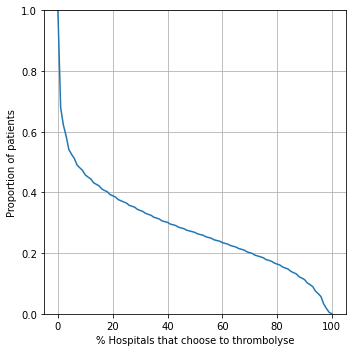

In [8]:
results['percent']

fig = plt.figure(figsize=(5,5))

# Agreement on treatment 
ax1 = fig.add_subplot(111)
xvals = np.arange(0,101,1)

y1 = [sum([1 for p in results.percent.values if p>=x])\
         /len(results.percent.values) for x in xvals]

ax1.plot(xvals, y1)
ax1.set_xlabel('% Hospitals that choose to thrombolyse')
ax1.set_ylabel('Proportion of patients')
ax1.set_ylim(0, 1)
ax1.grid()


plt.tight_layout()
plt.savefig('./output/prop_agree_to_receive_thrombolysis.jpg', dpi=300)
plt.show()

### Proportion agreeing

Split patients by:

1. All patients - any agreement

2. Patients who did receive thrombolysis: percent of hospitals that would agree to give thrombolysis

3. Patients who did not receive thrombolysis: percent of hospitals that would agree to not give thrombolysis

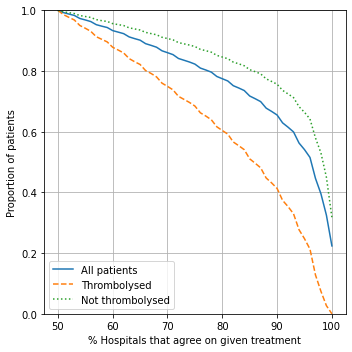

In [9]:
fig = plt.figure(figsize=(5,5))

# Agreement on treatment 
ax1 = fig.add_subplot(111)
xvals = np.arange(50,101,1)

y1 = [sum([1 for p in results.percent_agree.values if p>=x])\
         /len(results.percent_agree.values) for x in xvals]

ax1.plot(xvals, y1, label='All patients', linestyle='-')

y2 = [sum(1 for p in results[results['True']==1].percent_agree.values if p>=x)\
         /len(results[results['True']==1].percent_agree.values) for x in xvals]

ax1.plot(xvals, y2, label='Thrombolysed', linestyle='--')

y3 = [sum(1 for p in results[results['True']==0].percent_agree.values if p>=x)\
         /len(results[results['True']==0].percent_agree.values) for x in xvals]
      
ax1.plot(xvals, y3, label='Not thrombolysed', linestyle=':')
         
ax1.legend()

ax1.set_xlabel('% Hospitals that agree on given treatment')
ax1.set_ylabel('Proportion of patients')
ax1.set_ylim(0, 1)
ax1.grid()
      
plt.tight_layout()
plt.savefig('./output/agreement_x_hospital_single.jpg', dpi=300)
plt.show()

In [10]:
# Set percent of hospital to agree
xvals = [80, 90, 95]

# Find proportion of patients with agreement for either treat/no-treat decsion
agree_all = [sum([1 for p in results.percent_agree.values if p>=x])\
         /len(results.percent_agree.values) for x in xvals]

# Find proportion of thrombolysed patients with agreement
agree_thromb = [
    sum(1 for p in results[results['True']==1].percent_agree.values if p>=x)\
         /len(results[results['True']==1].percent_agree.values) for x in xvals]

# Find proportion of non-thrombolysed patients with agreement
agree_non_thromb = [
    sum(1 for p in results[results['True']==0].percent_agree.values if p>=x)\
         /len(results[results['True']==0].percent_agree.values) for x in xvals]

# Put in DataFrame
results_agree = pd.DataFrame()
results_agree['% Hospitals Agree'] = xvals
results_agree.set_index('% Hospitals Agree', inplace=True)
results_agree['Any'] = agree_all
results_agree['Throm'] = agree_thromb
results_agree['No Throm'] = agree_non_thromb
results_agree = results_agree.round(3)

results_agree

,Any,Throm,No Throm
% Hospitals Agree,,,
80,0.775,0.604,0.846
90,0.655,0.413,0.757
95,0.541,0.247,0.664


## Observations

* It is easier to find majority agreement on who not to thrombolyse than who to thrombolyse. For example:
    * 77.5% of all patients have a treatment decision that is agreed by 80% hospitals
    * Of those who were not given thrombolysis, 84.6% had agreement by 80% hospitals
    * Of those who were given thrombolysis, 60.4% had agreement by 80% hospitals 